In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import models
import utils
from vision_transformer import DINOHead
import vision_transformer as vits


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def unnormalize(X):
    """
    X: torch tensor or ndarray (..., 3, H, W)
    """
    if isinstance(X, type(np.ones((1,)))):
        means = np.asarray([0.485, 0.456, 0.406])
        stds =  np.asarray([0.229, 0.224, 0.225])
    else:
        means = torch.FloatTensor([0.485, 0.456, 0.406])
        stds = torch.FloatTensor([0.229, 0.224, 0.225])
    return X*stds[:,None,None] + means[:,None,None]

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


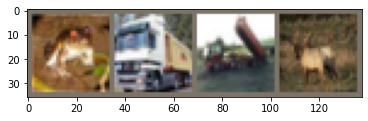

frog  truck truck deer 


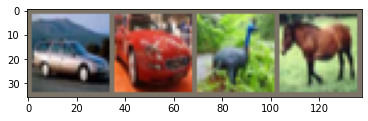

frog  truck truck deer 


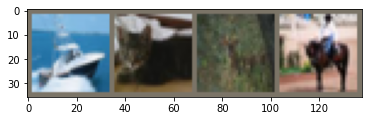

frog  truck truck deer 


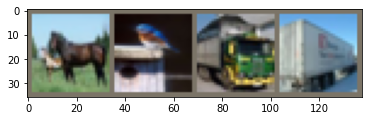

frog  truck truck deer 


In [3]:
# functions to show an image
def imshow(img):
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


j = 0
for i, data in enumerate(trainloader):
    if j > 3:
        break
    x, y = data
    imshow(torchvision.utils.make_grid(x))
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    j += 1

# show images
# imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans8-16-24-48ksizes2ncnns104/checkpoint.pth"
# imgnet
checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans12-16-24-36-48ksizes2ncnns6aggdim128share/checkpoint.pth"
# attnjoin
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/chans8-16-24-48ksizes2ncnns8attnjoin/checkpoint.pth"
# vit baseline
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/vit_tiny_baseline/checkpoint.pth"
#checkpt_path = "/mnt/fs1/grantsrb/dinoclr_saves/avgpoolchans8-16-16-16-24-24-24ksizes2/checkpoint.pth"
checkpt = torch.load(checkpt_path, map_location='cpu')
#kwgs = {
#    "n_cnns": 8,  
#    "inpt_shape": (3,32,32),                                       
#    #"chans": [8,16,16,16,24,24,24],
#    "chans": [8,16,24,48,96],
#    "ksizes": 2,                                     
#    "strides": 1,
#    "paddings": 0,
#    "lnorm": True,
#    "out_dim": 65536,
#}                                                                  
args = checkpt["args"]
if args.arch in vits.__dict__.keys():                                  
    kwgs = {                                                           
        "patch_size": args.patch_size,                                 
        "img_size": [32]
    }                                                                  
    teacher = vits.__dict__[args.arch]( **kwgs )                       
    embed_dim = teacher.embed_dim
    kwgs["inpt_shape"] = [3,32,32]
elif args.arch in models.__dict__.keys():                              
    kwgs = checkpt["hyps"]
    print(kwgs)
    teacher = models.__dict__[checkpt["args"].arch](**kwgs)
    embed_dim = kwgs["out_dim"]
teacher = utils.MultiCropWrapper(                                      
    teacher,                                                           
    DINOHead(embed_dim, checkpt["args"].out_dim, False),            
)
teacher.load_state_dict(checkpt["teacher"])

{'n_cnns': 6, 'inpt_shape': (3, 224, 224), 'chans': [12, 16, 24, 36, 48], 'ksizes': 2, 'strides': 1, 'paddings': 0, 'lnorm': True, 'h_size': 256, 'agg_fxn': 'AvgOverDim', 'out_dim': 128, 'share_base': True}


<All keys matched successfully>

In [10]:
def compute_saliency_maps(X, y, model, leaf_idx=0, inpt_shape=(32,32)):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.
    - leaf_idx: int, the index of the leaf cnn

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """

    N, C, H, W = X.shape
    if H != inpt_shape[-1]:
        diff = inpt_shape[-1]-H
        X = torch.nn.functional.pad(X, (diff//2, diff//2, diff//2, diff//2))
    model.eval()
    model.backbone.leaf_idx = leaf_idx
    X.requires_grad_()

    scores = model(X.cuda())
    loss = scores.sum()
    model.zero_grad()
    loss.backward()
    saliency = X.grad.data
    saliency, _ = saliency.abs().max(1)
    model.leaf_idx = None
    
    if H != inpt_shape[-1]:
        saliency = saliency[..., diff//2:-diff//2, diff//2:-diff//2]
    return saliency.cpu()

In [11]:
def show_saliency_maps(X, y, model, leaf_idx, inpt_shape=(32,32)):
    """
    Plot saliency maps for images X and labels y

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.
    - leaf_idx: int, the index of the leaf cnn

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    
    saliency = compute_saliency_maps(X.clone(), y, model, leaf_idx, inpt_shape=inpt_shape)

    saliency = saliency.detach().cpu().numpy()
    N = X.shape[0]
    X = unnormalize(X)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].detach().data.cpu().numpy().transpose((1,2,0)))
        plt.axis('off')
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

In [12]:
for p in teacher.parameters():
    p.requires_grad_(False)

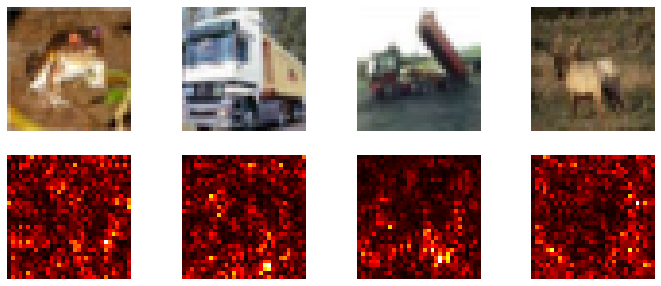

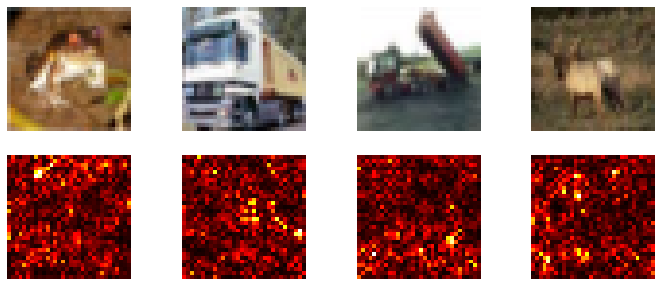

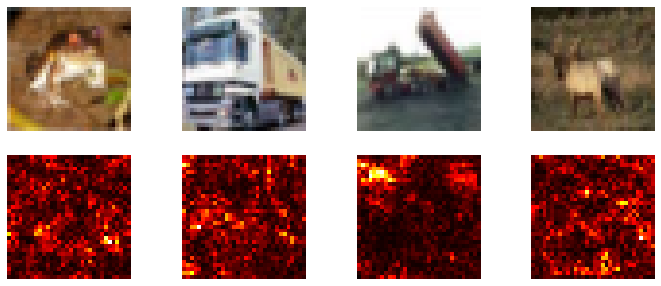

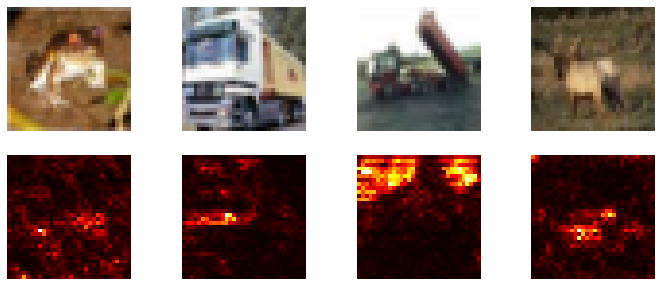

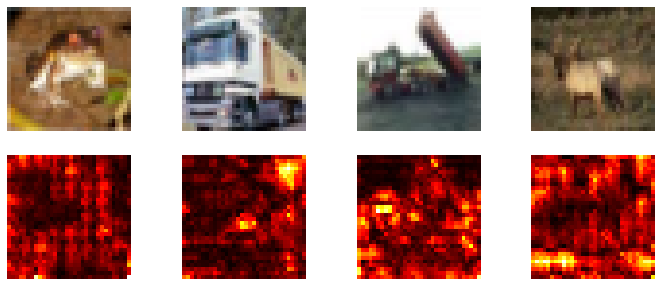

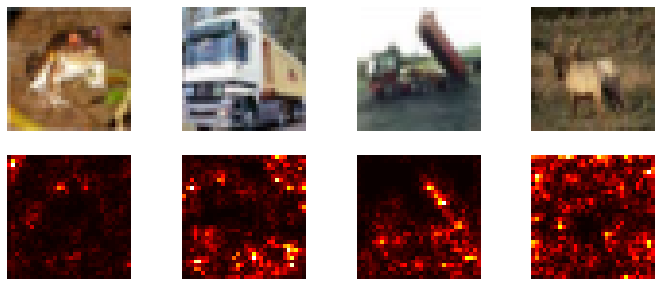

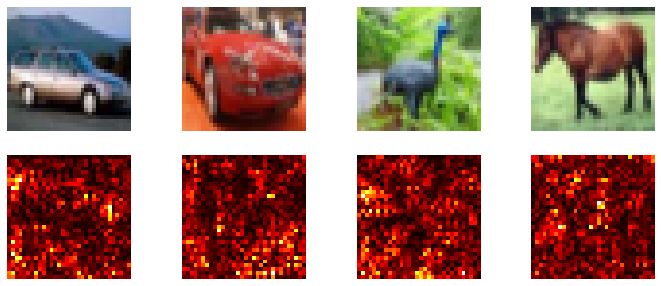

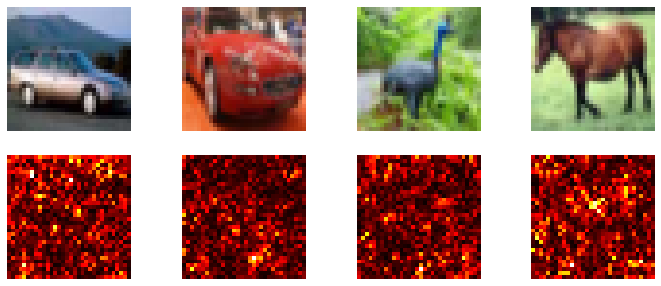

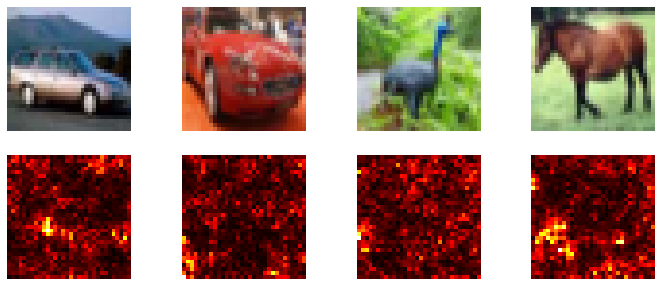

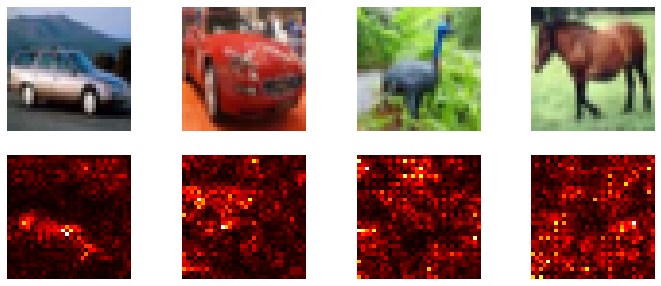

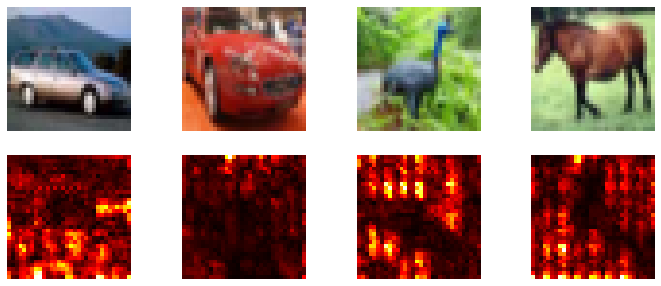

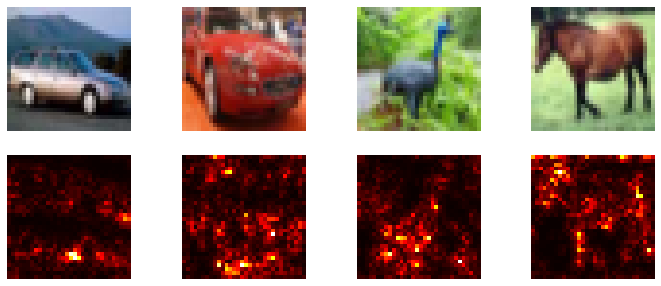

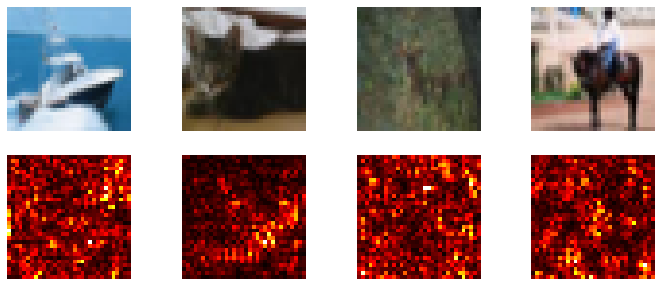

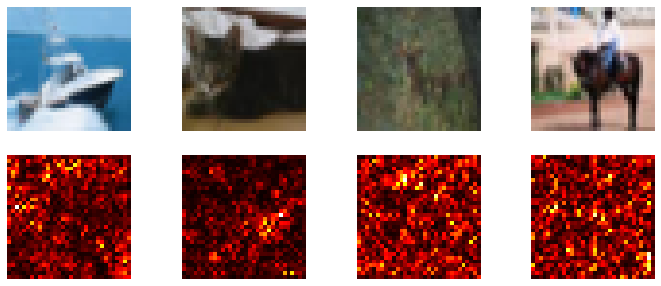

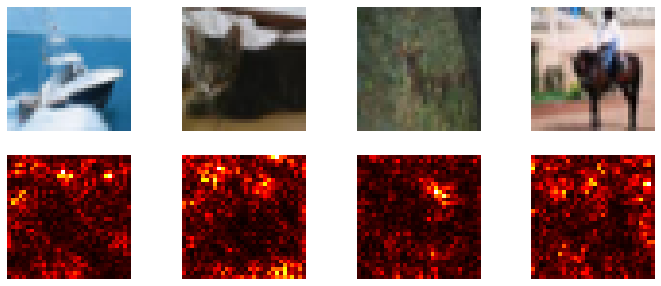

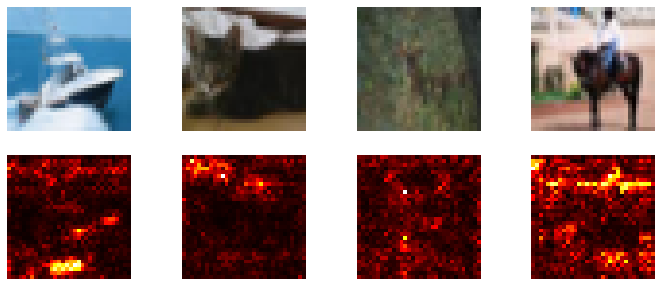

KeyboardInterrupt: 

In [13]:
dataiter = iter(trainloader)
teacher.cuda();
for i in range(10):
    X, y = dataiter.next()
    nloops = 1 if not hasattr(teacher.backbone, "n_cnns") else teacher.backbone.n_cnns
    for leaf in range(nloops):
        show_saliency_maps(X, y, teacher, leaf, inpt_shape=kwgs["inpt_shape"])
teacher.cpu();